In [ ]:
! pip install monashspa[PHS3302]

[monashspa:info] Unable to check if a newer version is available
[monashspa:info] You are running monashspa version: 1.5.5
[monashspa:info] You can find the latest version number at: https://monashspa.readthedocs.io
Relative resolution is 0.022


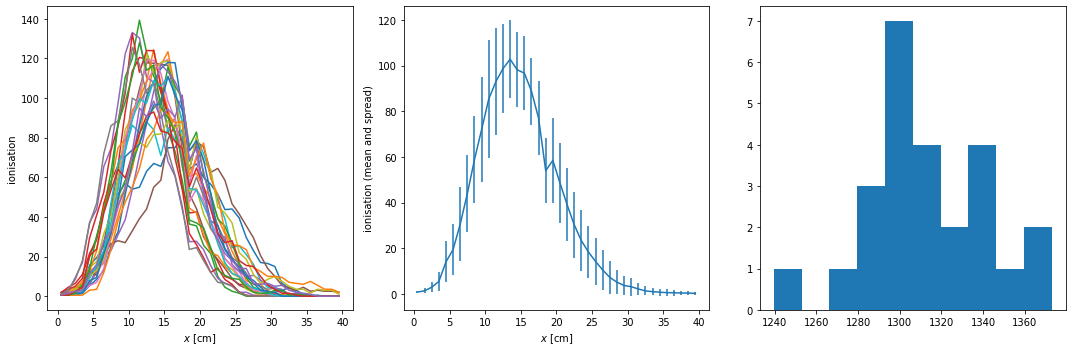

In [2]:
import random

import monashspa.PHS3302.calorimeter.model as model
import matplotlib.pyplot as plt
import numpy as np


# ## An example illustrating how the code works
# 
# Create the calorimeter. In this case a sampling calorimeter with interchaging
# layers of scintillator (low density, active) and lead (high density, inactive).

mycal = model.Calorimeter()

lead = model.Layer('lead', 2.0, 0.5, 0.0)
scintillator = model.Layer('Scin', 0.01, 0.5, 1.0)

for i in range(40):
    mycal.add_layers([lead, scintillator])


# Run a simulation


zcors = mycal.positions()

sim = model.Simulation(mycal)
ionisations = sim.simulate(model.Electron(0.0, 10.0), 25)

meanionisations = np.mean(ionisations, axis=0)
rmsionisations = np.std(ionisations, axis=0)
energies = np.sum(ionisations, axis=1)
rel_resolution = np.std(energies)/np.mean(energies)

print(f'Relative resolution is {rel_resolution:.3f}')


# Create some plots

fig = plt.figure(figsize=(15,5))
ax1, ax2, ax3 = fig.subplots(1, 3)
for i in ionisations:
    ax1.plot(zcors, i)
ax1.set_xlabel(r'$x$ [cm]')
ax1.set_ylabel(r'ionisation')

ax2.errorbar(zcors, meanionisations, yerr=rmsionisations)
ax2.set_xlabel(r'$x$ [cm]')
ax2.set_ylabel(r'ionisation (mean and spread)')

ax3.hist(energies)

plt.tight_layout()
plt.show()

In [3]:
# # Your exercise should start here

# ## Study energy resolution
# Make a plot of the relative energy resolution, $\sigma(E)/E$ for particles between 1 and 10 GeV.
# You should be able to demonstrate that the resolution is proportional to $1/\sqrt{E}$.
# This will require that you run the simulation code above inside a loop to get number for multiple
# different energies.

particle_energies = np.logspace(0.0, 1.1, 10)


# 2 marks: Create loop to find resolutions for different energies
# 2 marks: Create plot of the relative energy resolution vs. energy
# 2 marks: Document that it shows the $1/\sqrt{E}$ behaviour through a fit or similar

In [4]:
# ## Noise
# Modify the code such that when reading out the total ionisation from a layer, a noise term is added.
# The noise is a random amount from a Gaussian distribution that is added to the ionisation for active
# layers. Demonstrate how this is only relevant for the relative resolution when the ingoing particle
# has low energy. Identify a noise level yourself that illustrates the effect well.

# 2 marks. Add noise term correctly as an additive term on a per layer basis.
# 2 marks: Create aplot that shows the new relative energy resolution.
# 2 marks: Comparison in one form or the other to situation without the noise.

In [5]:
# ## Calibration
# Study how mis-calibration of layers will affect the resolution. Implement this by scaling the
# total ionisation collected in all layers for a given particle by a random value. The scaling factor
# should be close to 1.0. Demonstrate how this is most relevant for the relative resolution when the
# ingoing particle has high energy.

# 2 marks. Add calibration term correctly as a multiplicative term on the overall ionisation.
# 2 marks: Create a plot that shows the new relative energy resolution.
# 2 marks: Comparison in one form or the other to situation without the mis-calibration.

In [6]:
# ## Fit an overall resolution
# 
# Put everything together, so that you have a simulation that considers both noise and calibration.
# Implement a fit that determines the a, b anc c parameters of a calorimeter resolution model:
# $\frac{\sigma(E)}{E} = \frac{a}{\sqrt{E}} \oplus b \oplus \frac{c}{E}$.


if False:
    # Fill these arrays with the relative resolution and the uncertainty on that estimate for each of the
    # particle energies
    rel_resolutions_withall = []
    u_rel_resolutions_withall = []

    from lmfit import fit_report
    from scipy import stats
    from monashspa.common.fitting import linear_fit, get_fit_parameters, make_lmfit_model, model_fit
    from monashspa.common.figures import savefig

    name='Energy resolution'
    model = make_lmfit_model("sqrt(a*a/x + b*b + c*c/(x*x))")
    params = model.make_params(a=0.09, b=0.03, c=3)
    fit_results = model_fit(model, params, particle_energies, rel_resolutions_withall, u_y=u_rel_resolutions_withall)

    # Extract result and print nicely
    fit = fit_results.best_fit
    u_fit = fit_results.eval_uncertainty(sigma=1)
    fit_parameters = get_fit_parameters(fit_results)
    pvalue = 1.0 - stats.chi2.cdf(fit_results.chisqr,
                                  fit_results.ndata-fit_results.nvarys)

    print("""
    [[{name}]]
    =================
      p-value       = {pvalue:.2E}
    """.format(name=name, pvalue=pvalue))
    print(fit_results.fit_report())

    # Create some plots
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    ax1.errorbar(particle_energies, rel_resolutions_withall, yerr=u_rel_resolutions_withall, marker="x", linestyle="None", color="black",label="Energy resolution")
    ax1.plot(particle_energies, fit, marker="None", linestyle="-", color="black",label="fit to {name}".format(name=name))
    ax1.fill_between(particle_energies, fit-u_fit,fit+u_fit,
                     color="lightgrey",label="uncertainty in {name}".format(name=name))
    ax1.legend(bbox_to_anchor=(0.3,1))
    ax1.set(ylabel="resolution")
    pull = (rel_resolutions_withall-fit)/u_rel_resolutions_withall
    ax2.plot(particle_energies, pull, marker="*", linestyle="None", color="black")
    emin = np.min(particle_energies)
    emax = np.max(particle_energies)
    ax2.plot([emin, emax], [ 0, 0], marker="None", linestyle="-", color="grey")
    ax2.plot([emin, emax], [ 1, 1], marker="None", linestyle="dashed", color="grey")
    ax2.plot([emin, emax], [-1,-1], marker="None", linestyle="dashed", color="grey")
    ax2.set(xlabel="x", ylabel="Pull")
    scale = 1.1*np.max(np.abs(pull))
    ax2.set_ylim(-scale, scale)
    fig.suptitle('Fit with {name}'.format(name=name))

    plt.show()

# 2 marks. Simulate data with both noise and mis-calibration
# 2 marks: Fit the simulated data
# 2 marks: Interpret results